In [1]:
""" Python Standard Library """
import os
import datetime as dt

import json
import logging
""" Third Party Imports """
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
""" Local Imports """
if 'requirements.txt' not in os.listdir(os.getcwd()):
    os.chdir(os.path.join('..','..','..'))
print(os.getcwd())
from covid_model import CovidModel
from covid_model.runnable_functions import do_single_fit, do_create_report
from covid_model.utils import setup, get_filepath_prefix
from covid_model.analysis.charts import plot_transmission_control

os.environ['gcp_project'] = 'co-covid-models'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "co-covid-models-credentials.json"

outdir = setup("variant_share_qc.ipynb")

/Users/brittney/covid-models


2022/08/22 08:32:16 INFO|============================================================


In [3]:
import pandas as pd
obs_fpath = "covid_model/model_dev_qc/variants/CDPHE Variant Data (manually transcribed and limited to model variants).csv"
obs = pd.read_csv(obs_fpath, parse_dates=['Date']).fillna(0)
obs['Date'] = [d.date() for d in obs['Date']]
obs = obs.set_index('Date')

In [4]:
seeds = [
    {"param": "omicron_seed", "attrs": None, "vals": {"2020-01-01": 0, "2021-11-09": 1, "2021-12-11": 0}, "desc": "1 BA.1 seed is planted each day starting November 9th, 2021 and ending December 11th, 2021"},
    {"param": "ba2_seed", "attrs": None, "vals": {"2020-01-01": 0, "2021-12-23": 5, "2022-02-02": 0}, "desc": "5 BA.2 seeds are planted each day starting December 23rd, 2021 and ending February 2nd, 2022"},
    {"param": "ba2121_seed", "attrs": None, "vals": {"2020-01-01": 0, "2022-02-27": 5, "2022-04-08": 0}, "desc": "5 BA.2.12.1 seeds are planted each day starting February 27th, 2022 and ending April 8th, 2022"},
    {"param": "ba45_seed", "attrs": None, "vals": {"2020-01-01": 0, "2022-04-05": 5, "2022-05-15": 0}, "desc": "5 BA.4/5 seeds are planted each day started April 5th, 2022 and ending May 15, 2022"},
    {"param": "immune_escape", "from_attrs": {"variant": "none", "immun": "weak"},  "to_attrs": {"variant": "delta"}, "vals": {"2020-01-01": 0.375}, "desc": "37.5% of weakly immune individuals can get reinfected with Delta"},
    {"param": "immune_escape", "from_attrs": {"immun": "strong", "variant": ["none", "wildtype", "alpha", "delta"]}, "to_attrs": {"variant": ["omicron", "ba2", "ba2121"]}, "vals": {"2020-01-01": 0.1}, "desc": "given prior infection with a pre-Omicron variant, 10% of strongly immune individuals can get reinfected with BA.1, BA.2, or BA.2.12.1"},
    {"param": "immune_escape", "from_attrs": {"immun": "weak", "variant": ["none", "wildtype", "alpha", "delta"]}, "to_attrs": {"variant": ["omicron", "ba2", "ba2121"]}, "vals": {"2020-01-01": 0.75}, "desc": "given prior infection with a pre-Omicron variant, 75% of weakly immune individuals can get reinfected with BA.1, BA.2, or BA.2.12.1"},
    {"param": "immune_escape", "from_attrs": {"immun": "strong", "variant": ["omicron", "ba2"]}, "to_attrs": {"variant": ["ba2121"]}, "vals": {"2020-01-01": 0.03}, "desc": "given prior infection with BA.1 or BA.2, 3% of strongly immune individuals can get reinfected with BA.2.12.1"},
    {"param": "immune_escape", "from_attrs": {"immun": "weak", "variant": ["omicron", "ba2"]}, "to_attrs": {"variant": ["ba2121"]}, "vals": {"2020-01-01": 0.25}, "desc": "given prior infection with BA.1 or BA.2, 25% of weakly immune individuals can get reinfected with BA.2.12.1"},
    {"param": "immune_escape", "from_attrs": {"immun": "strong", "variant": ["none", "wildtype", "alpha", "delta"]}, "to_attrs": {"variant": ["ba45"]}, "vals": {"2020-01-01": 0.15}, "desc": "given prior infection with a pre-Omicron variant, 15% of strongly immune individuals can get reinfected with BA.4/5"},
    {"param": "immune_escape", "from_attrs": {"immun": "weak", "variant": ["none", "wildtype", "alpha", "delta"]}, "to_attrs": {"variant": ["ba45"]}, "vals": {"2020-01-01": 0.80}, "desc": "given prior infection with a pre-Omicron variant, 80% of weakly immune individuals can get reinfected with BA.4/5"},
    {"param": "immune_escape", "from_attrs": {"immun": "strong", "variant": ["omicron", "ba2", "ba2121"]}, "to_attrs": {"variant": ["ba45"]}, "vals": {"2020-01-01": 0.04}, "desc": "given prior infection with an Omicron variant, 4% of strongly immune individuals can get reinfected with BA.4/5"},
    {"param": "immune_escape", "from_attrs": {"immun": "weak", "variant": ["omicron", "ba2", "ba2121"]}, "to_attrs": {"variant": ["ba45"]}, "vals": {"2020-01-01": 0.40}, "desc": "given prior infection with an Omicron variant, 40% of weakly immune individuals can get reinfected with BA.4/5"},
    {"param": "severe_immunity", "attrs": {"immun": ["strong", "weak"]}, "vals": {"2020-01-01": 0.975}, "desc": "97.5% of people with some level of immunity are protected against severe disease"},
    {"param": "severe_immunity", "attrs": {"immun": ["strong", "weak"], "vacc": "none"}, "vals": {"2020-01-01": 0.5}, "desc": "unvaccinated individuals whose immunity was conferred by natural infection have 47.5% less protection against severe disease than those whose strong or weak immunity was conferred by vaccination"},
    {"param": "severe_immunity", "attrs": {"variant": "delta"}, "mults": {"2020-01-01": 0.9}, "desc": "90% of people with a prior Delta infection are protected against severe disease"},
    {"param": "severe_immunity", "attrs": {"vacc": ["shot1", "shot2"], "variant": ["omicron", "ba2", "ba2121", "ba45"]}, "mults": {"2020-01-01": 0.7}, "desc": "70% of people who have completed a vaccine series are protected against severe Omicron"},
    {"param": "severe_immunity", "attrs": {"vacc": ["booster1", "booster2"], "variant": ["omicron", "ba2", "ba2121", "ba45"]}, "mults": {"2020-01-01": 0.9}, "desc": "90% of people who have been boosted are protected against severe Omicron"},
]

model_args = {
    'params_defs': json.load(open('covid_model/model_dev_qc/qc_params.json')) + seeds,
    'region_defs': 'covid_model/input/region_definitions.json',
    'vacc_proj_params': 'covid_model/input/vacc_proj_params.json',
    'regions': ['co'],
    'mobility_mode': None,
    'start_date': '2020-01-24',
    'end_date': '2022-10-15',
    'max_step_size': 1.0,
    'ode_method': 'RK45',
    'hosp_reporting_frac': {"2020-01-01": 1, "2022-03-01": 0.932, "2022-03-15": 0.868, "2022-03-30": 0.8}
}
model_args = {'base_spec_id': 3470, #model.spec_id
              'update_data': False}
fit_args = {
    #'fit_start_date': '2022-3-01',
    #'fit_end_date': '2022-05-01',
    'tc_min': 0.0,
    'tc_max': 0.999,
    'tc_window_size': 14,
    'tc_window_batch_size': 6,
    'tc_batch_increment': 2,
    'last_tc_window_min_size': 14,
    'outdir': outdir
}
model = CovidModel(**model_args)
model.prep(outdir=outdir)

2022/08/22 08:37:07 INFO|----------------------|{'fit_batch': '24', 'run_type': 'fit'} Prepping Model


In [5]:
#model.solve_seir()
model = do_single_fit(**fit_args, base_model = model, prep_model=False)

2022/08/22 08:39:00 INFO|-------------------------|{'fit_batch': '24', 'run_type': 'fit'} Retrieving vaccinations data
2022/08/22 08:39:08 INFO|-------------------------|{'fit_batch': '24', 'run_type': 'fit'} Constructing vaccination projections
2022/08/22 08:39:08 INFO|-------------------------|{'fit_batch': '24', 'run_type': 'fit'} Retrieving hospitalizations data
2022/08/22 08:39:21 INFO|----------------------|{'fit_batch': '24', 'run_type': 'fit'} Will fit 31 times
2022/08/22 08:45:11 INFO|----------------------|{'fit_batch': '0', 'run_type': 'fit'}: Transmission control fit 1/31 completed in 350.496861 seconds: {0: {'co': 0.8773342372139796}, 14: {'co': 0.68487910288407}, 28: {'co': 0.5387225729435073}, 42: {'co': 0.0003741632430747711}, 56: {'co': 0.681619090756707}, 70: {'co': 0.8911902599425514}}
2022/08/22 08:45:11 INFO|-----------------------|{'fit_batch': '0', 'run_type': 'fit'}: Running forward sim
2022/08/22 08:46:26 INFO|----------------------|{'fit_batch': '1', 'run_type

2022/08/22 09:01:39 INFO|-----------------------|{'fit_batch': '16', 'run_type': 'fit'}: Running forward sim
2022/08/22 09:02:31 INFO|----------------------|{'fit_batch': '17', 'run_type': 'fit'}: Transmission control fit 18/31 completed in 49.98728525000001 seconds: {476: {'co': 0.8003384222832239}, 490: {'co': 0.838591308020849}, 504: {'co': 0.7984062209719711}, 518: {'co': 0.7902684400153206}, 532: {'co': 0.7772119872958904}, 546: {'co': 0.7162954672103156}}
2022/08/22 09:02:31 INFO|-----------------------|{'fit_batch': '17', 'run_type': 'fit'}: Running forward sim
2022/08/22 09:03:24 INFO|----------------------|{'fit_batch': '18', 'run_type': 'fit'}: Transmission control fit 19/31 completed in 50.724566290999974 seconds: {504: {'co': 0.7977162143576464}, 518: {'co': 0.7923907014009126}, 532: {'co': 0.7713246408441519}, 546: {'co': 0.7261267566929213}, 560: {'co': 0.758394615990839}, 574: {'co': 0.7537571363086262}}
2022/08/22 09:03:24 INFO|-----------------------|{'fit_batch': '18'

2022/08/22 09:20:46 INFO|-----------------------|{'fit_batch': '30', 'run_type': 'fit'}: Running forward sim
2022/08/22 09:20:47 INFO|----------------------|{'fit_batch': '30', 'run_type': 'fit'}: Uploading final results
2022/08/22 09:20:55 INFO|----------------------|{'fit_batch': '30', 'run_type': 'fit'}: spec_id: 3557


In [6]:
model.solve_seir()
soln = model.solution_sum_df(['seir', 'variant'])

In [7]:
start_date = dt.datetime.strptime('2022-01-01', '%Y-%m-%d').date()
end_date = dt.datetime.strptime('2022-07-03', '%Y-%m-%d').date()
rows = (soln.index.get_level_values(0) >= start_date) & (soln.index.get_level_values(0) <= end_date)
cols = [any(colname == seir for seir in ['Ih', 'I', 'A']) for colname in soln.columns.get_level_values(0)]
infected_by_variant = soln.loc[rows, cols].groupby('variant', axis=1).sum()

In [44]:
start_date = dt.datetime.strptime('2020-01-01', '%Y-%m-%d').date()
end_date = dt.datetime.strptime('2022-07-03', '%Y-%m-%d').date()
rows = (soln.index.get_level_values(0) >= start_date) & (soln.index.get_level_values(0) <= end_date)
cols = [any(colname == seir for seir in ['Ih', 'I', 'A']) for colname in soln.columns.get_level_values(0)]
infected_by_variant = soln.loc[rows, cols].groupby('variant', axis=1).sum()

<AxesSubplot:xlabel='date'>

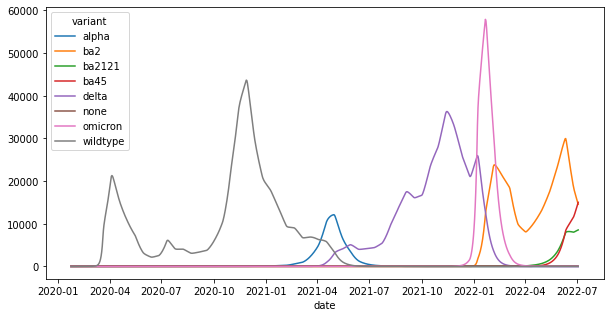

In [45]:
infected_by_variant.plot(figsize=(10, 5))

<AxesSubplot:xlabel='date'>

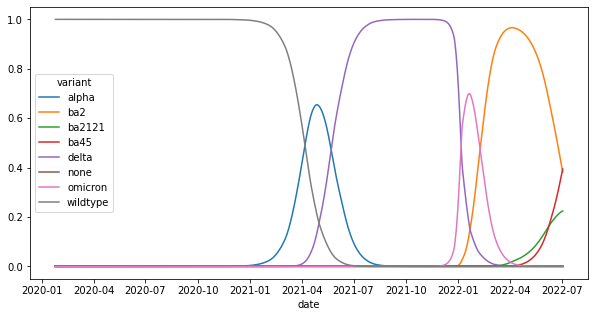

In [46]:
infected_by_variant.div(infected_by_variant.sum(axis=1), axis=0).plot(figsize=(10, 5))

In [53]:
# Saves data from plot above to .csv file - may need to update file path and name depending on preferences
new_infected_by_variant = infected_by_variant.div(infected_by_variant.sum(axis=1), axis=0)
new_df = pd.DataFrame(new_infected_by_variant)
new_df.to_csv('./norm_variant_prev.csv')

<AxesSubplot:xlabel='Date'>

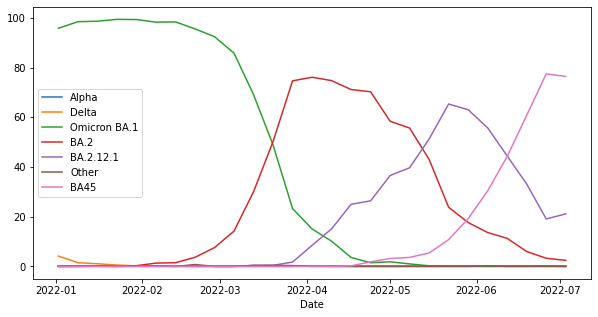

In [12]:
obs_rows = (obs.index.values >= start_date) & (obs.index.values <= end_date)
obs['BA45'] = obs['BA.4'] + obs['BA.5']
obs.drop(columns=['BA.4', 'BA.5']).loc[obs_rows,].plot(figsize=(10,5))

<AxesSubplot:xlabel='date'>

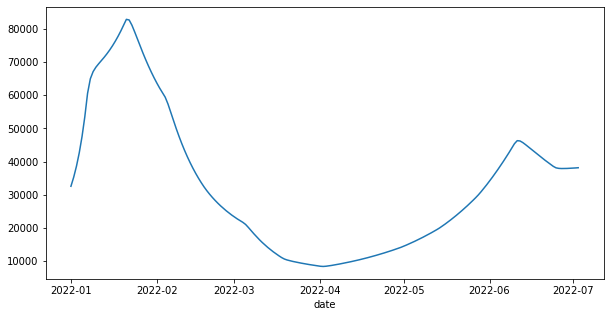

In [13]:
infected_by_variant.sum(axis=1).plot(figsize=(10, 5))

<AxesSubplot:xlabel='region,date'>

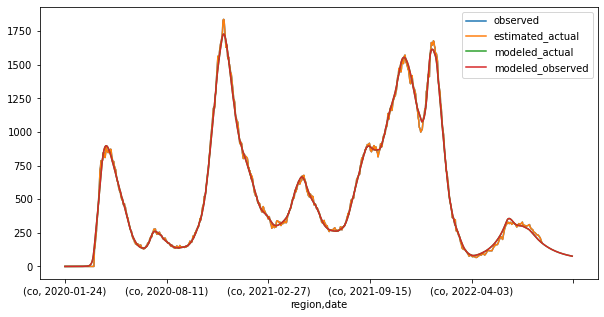

In [14]:
model.modeled_vs_observed_hosps().plot(figsize=(10,5))

In [15]:
do_create_report(model, outdir)

2022/08/22 09:21:50 WARNING|No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
